In [1]:
import sklearn
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold,cross_val_score
from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_recall_curve,auc,roc_auc_score,recall_score,classification_report
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict
from sklearn import svm
import random
from sklearn.model_selection import KFold
import missingno as msno
from IPython.display import display, Markdown
import pickle
from sklearn import metrics
from pandas import Series
from collections import defaultdict

C:\Users\Ankur\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Ingestion

In [2]:
df=pd.read_csv('aps_failure_training_set.csv',error_bad_lines=False)
df_test=pd.read_csv('aps_failure_test_set.csv',error_bad_lines=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 20.9+ MB


In [5]:
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


## Data Manipulation
#### Lets rename the target column to Flag and map neg to 0 and pos to 1 . Also map the na values to NULL.

In [6]:
df = df.rename(columns = {'class' : 'Flag'})
df['Flag'] = df.Flag.map({'neg':0, 'pos':1})
df = df.replace(['na'],np.nan)

## Exploratory Data Analysis

To check how many columns have NAs

In [7]:
# Checking Null Values
df.apply(lambda x: sum(x.isnull()), axis=0)

Flag          0
aa_000        0
ab_000    46329
ac_000     3335
ad_000    14861
ae_000     2500
af_000     2500
ag_000      671
ag_001      671
ag_002      671
ag_003      671
ag_004      671
ag_005      671
ag_006      671
ag_007      671
ag_008      671
ag_009      671
ah_000      645
ai_000      629
aj_000      629
ak_000     4400
al_000      642
am_0        629
an_000      642
ao_000      589
ap_000      642
aq_000      589
ar_000     2723
as_000      629
at_000      629
          ...  
dl_000     4008
dm_000     4009
dn_000      691
do_000     2724
dp_000     2726
dq_000     2726
dr_000     2726
ds_000     2727
dt_000     2727
du_000     2726
dv_000     2726
dx_000     2723
dy_000     2724
dz_000     2723
ea_000     2723
eb_000     4007
ec_00     10239
ed_000     9553
ee_000      671
ee_001      671
ee_002      671
ee_003      671
ee_004      671
ee_005      671
ee_006      671
ee_007      671
ee_008      671
ee_009      671
ef_000     2724
eg_000     2723
Length: 171, dtype: int6

From the above script, we can conclude that almost all the columns have NAs

Text(0,0.5,'Frequency')

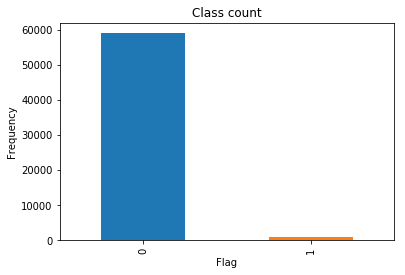

In [8]:
Count = pd.value_counts(df['Flag'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Class count")
plt.xlabel("Flag")
plt.ylabel("Frequency")

This is highly imbalanced data set. We will have to do some sampling technique here before modelling.

I am imputing the NA values in our data with the median value to get the central tendency or behaviour of trucks.

Since we have already created a model with whole data and its runtime were on a little high side,I am going to do a PCA to the dataset to imporve its performance,

Here, we are using a median normalization before PCA and Choosing the components which explains 95% of the variance in the data.

### Principal Component Analysis

In [9]:
# Principal Component Analysis
df_X = df.loc[:,df.columns != 'Flag']
df_Y = df.loc[:,df.columns == 'Flag']

df_X = df_X.apply(pd.to_numeric)

df_X= df_X.fillna(df_X.median()).dropna(axis =1 , how ='all')

scaler = StandardScaler()
scaler.fit(df_X)

df_X = scaler.transform(df_X)

pca = PCA(0.95)
pca.fit(df_X)

pca_n=pca.n_components_
pca_n

81

We have reduced number of columns from 171 to 81 here which explains 95 % of the data. Now lets transform our data.

In [10]:
df_X = pca.transform(df_X)
df_X= pd.DataFrame(df_X)

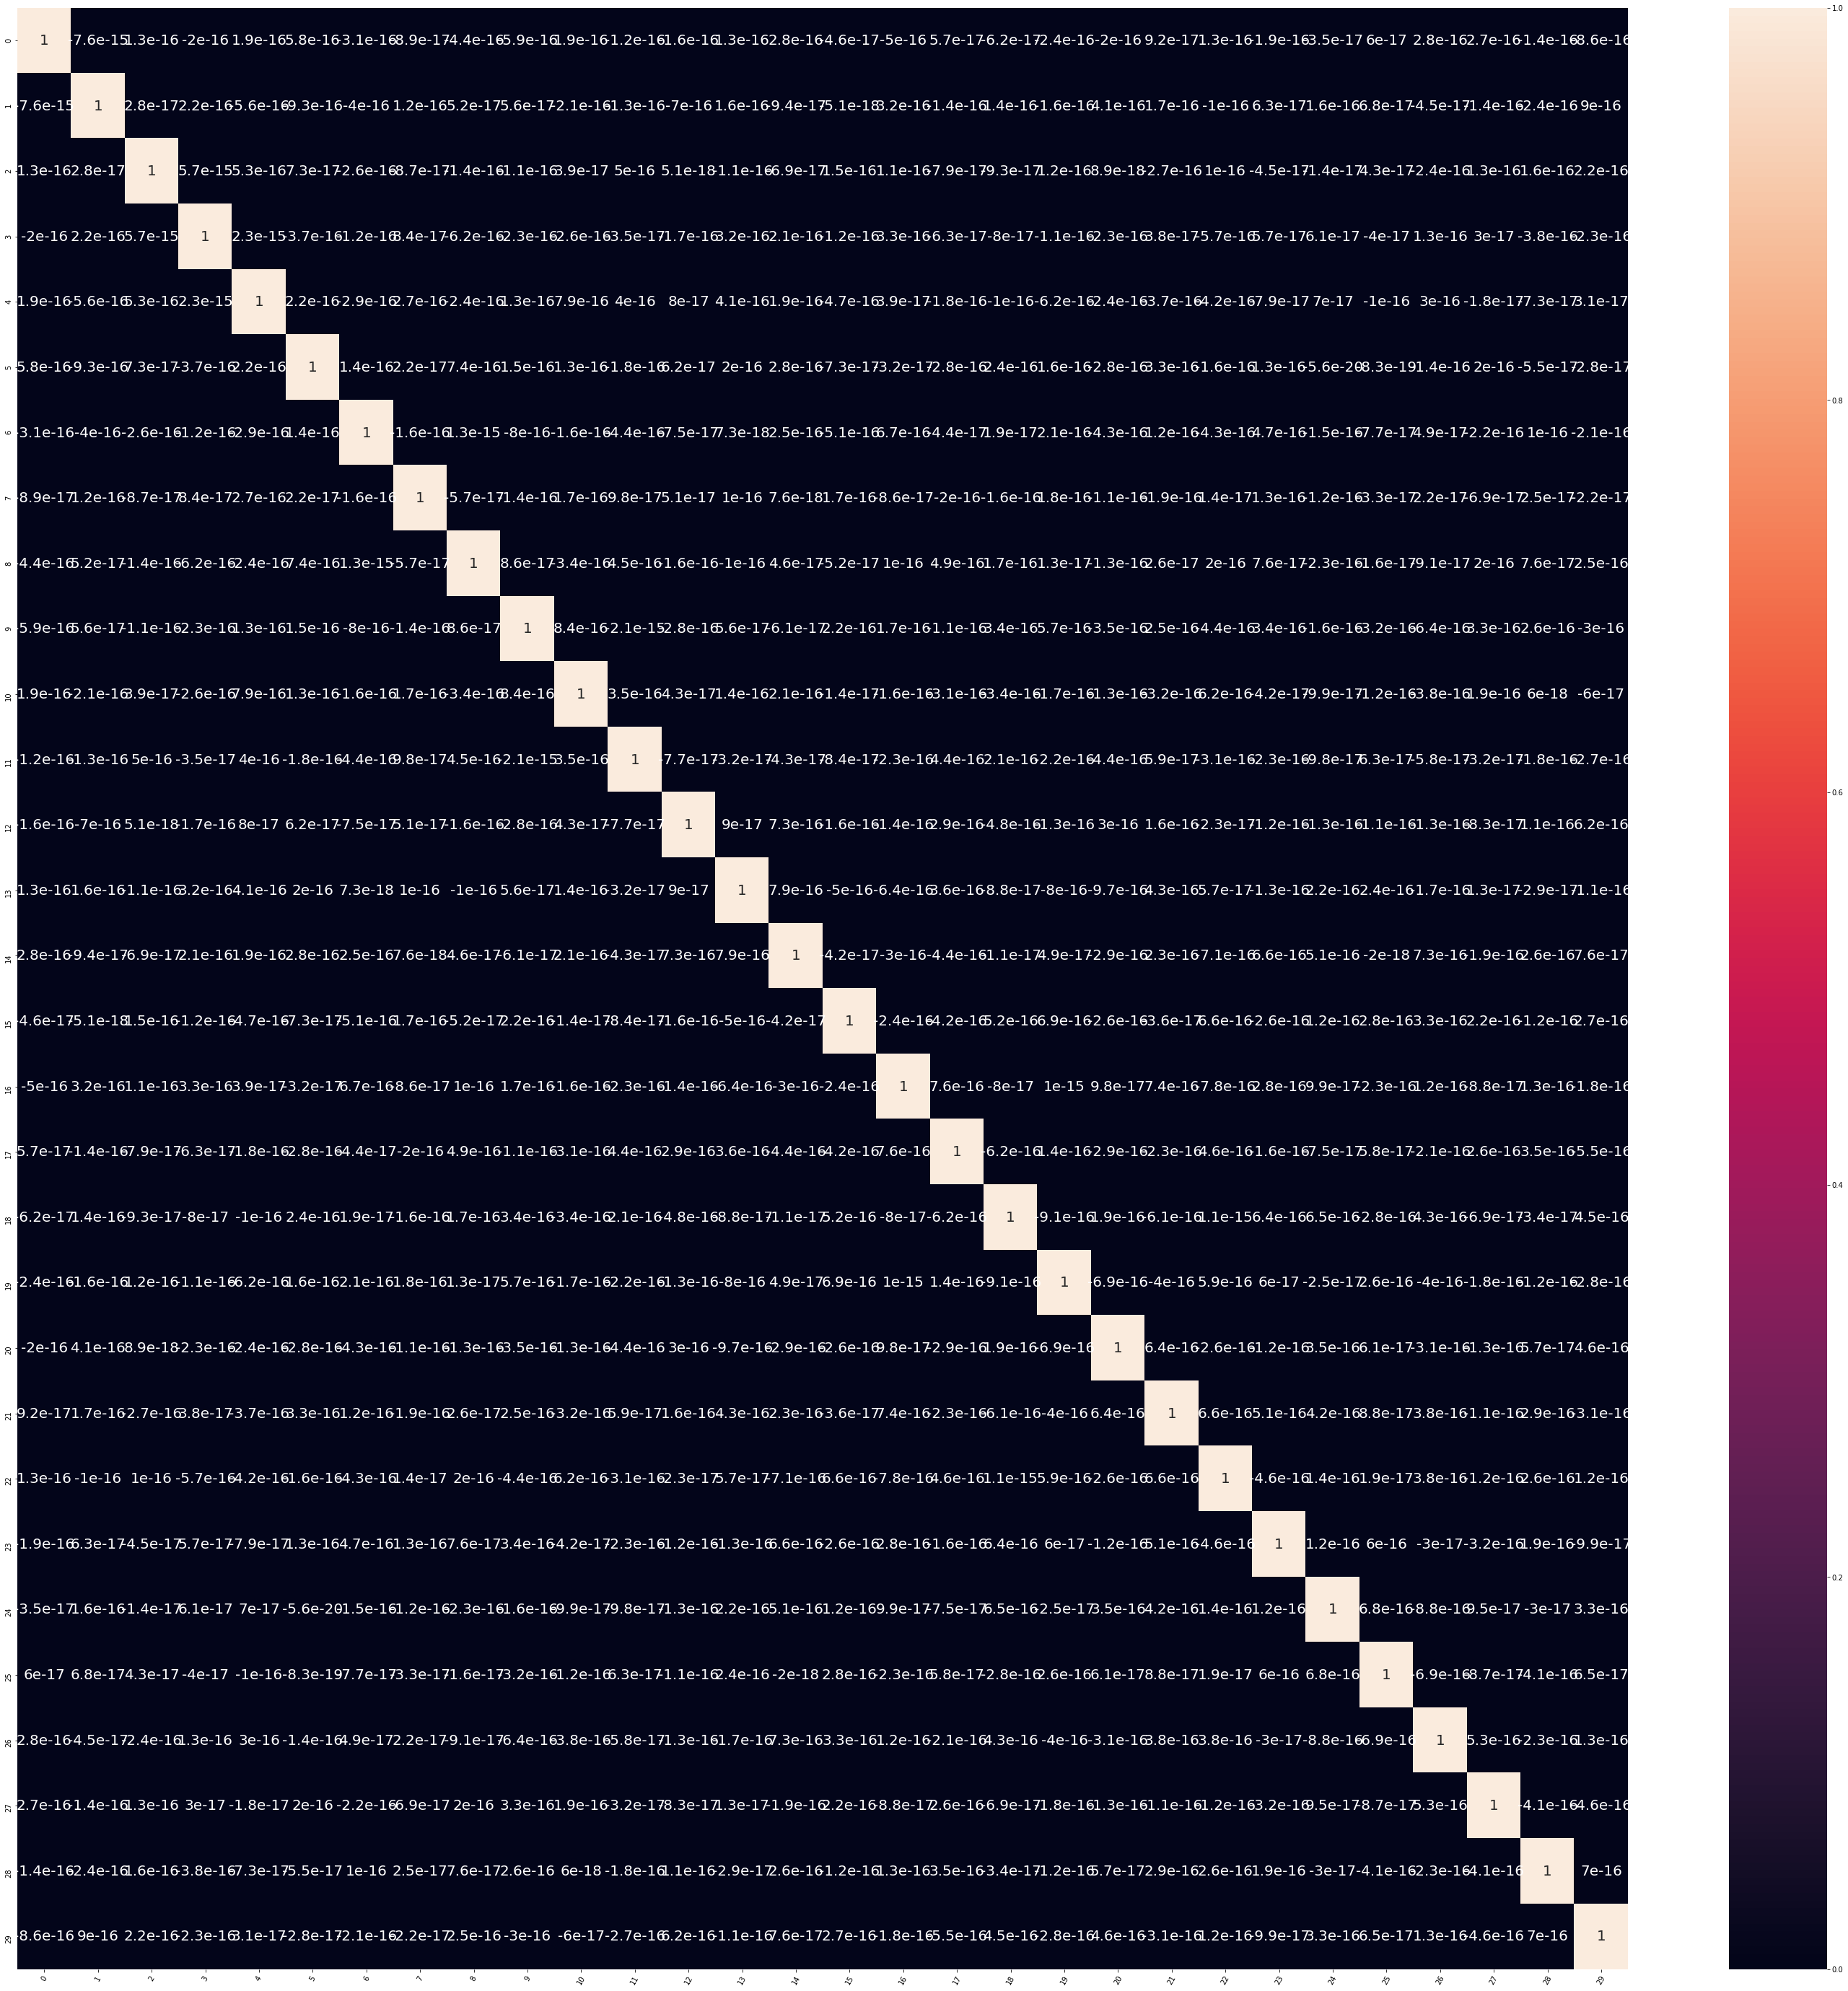

In [11]:
#Correlation Heat Map fo first 30 columns
df_x_30=df_X.iloc[:,0:30]
plt.figure(figsize=(50,50));
a = sns.heatmap(df_x_30.corr(), annot=True, annot_kws={"size": 20});
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=60)
plt.show();

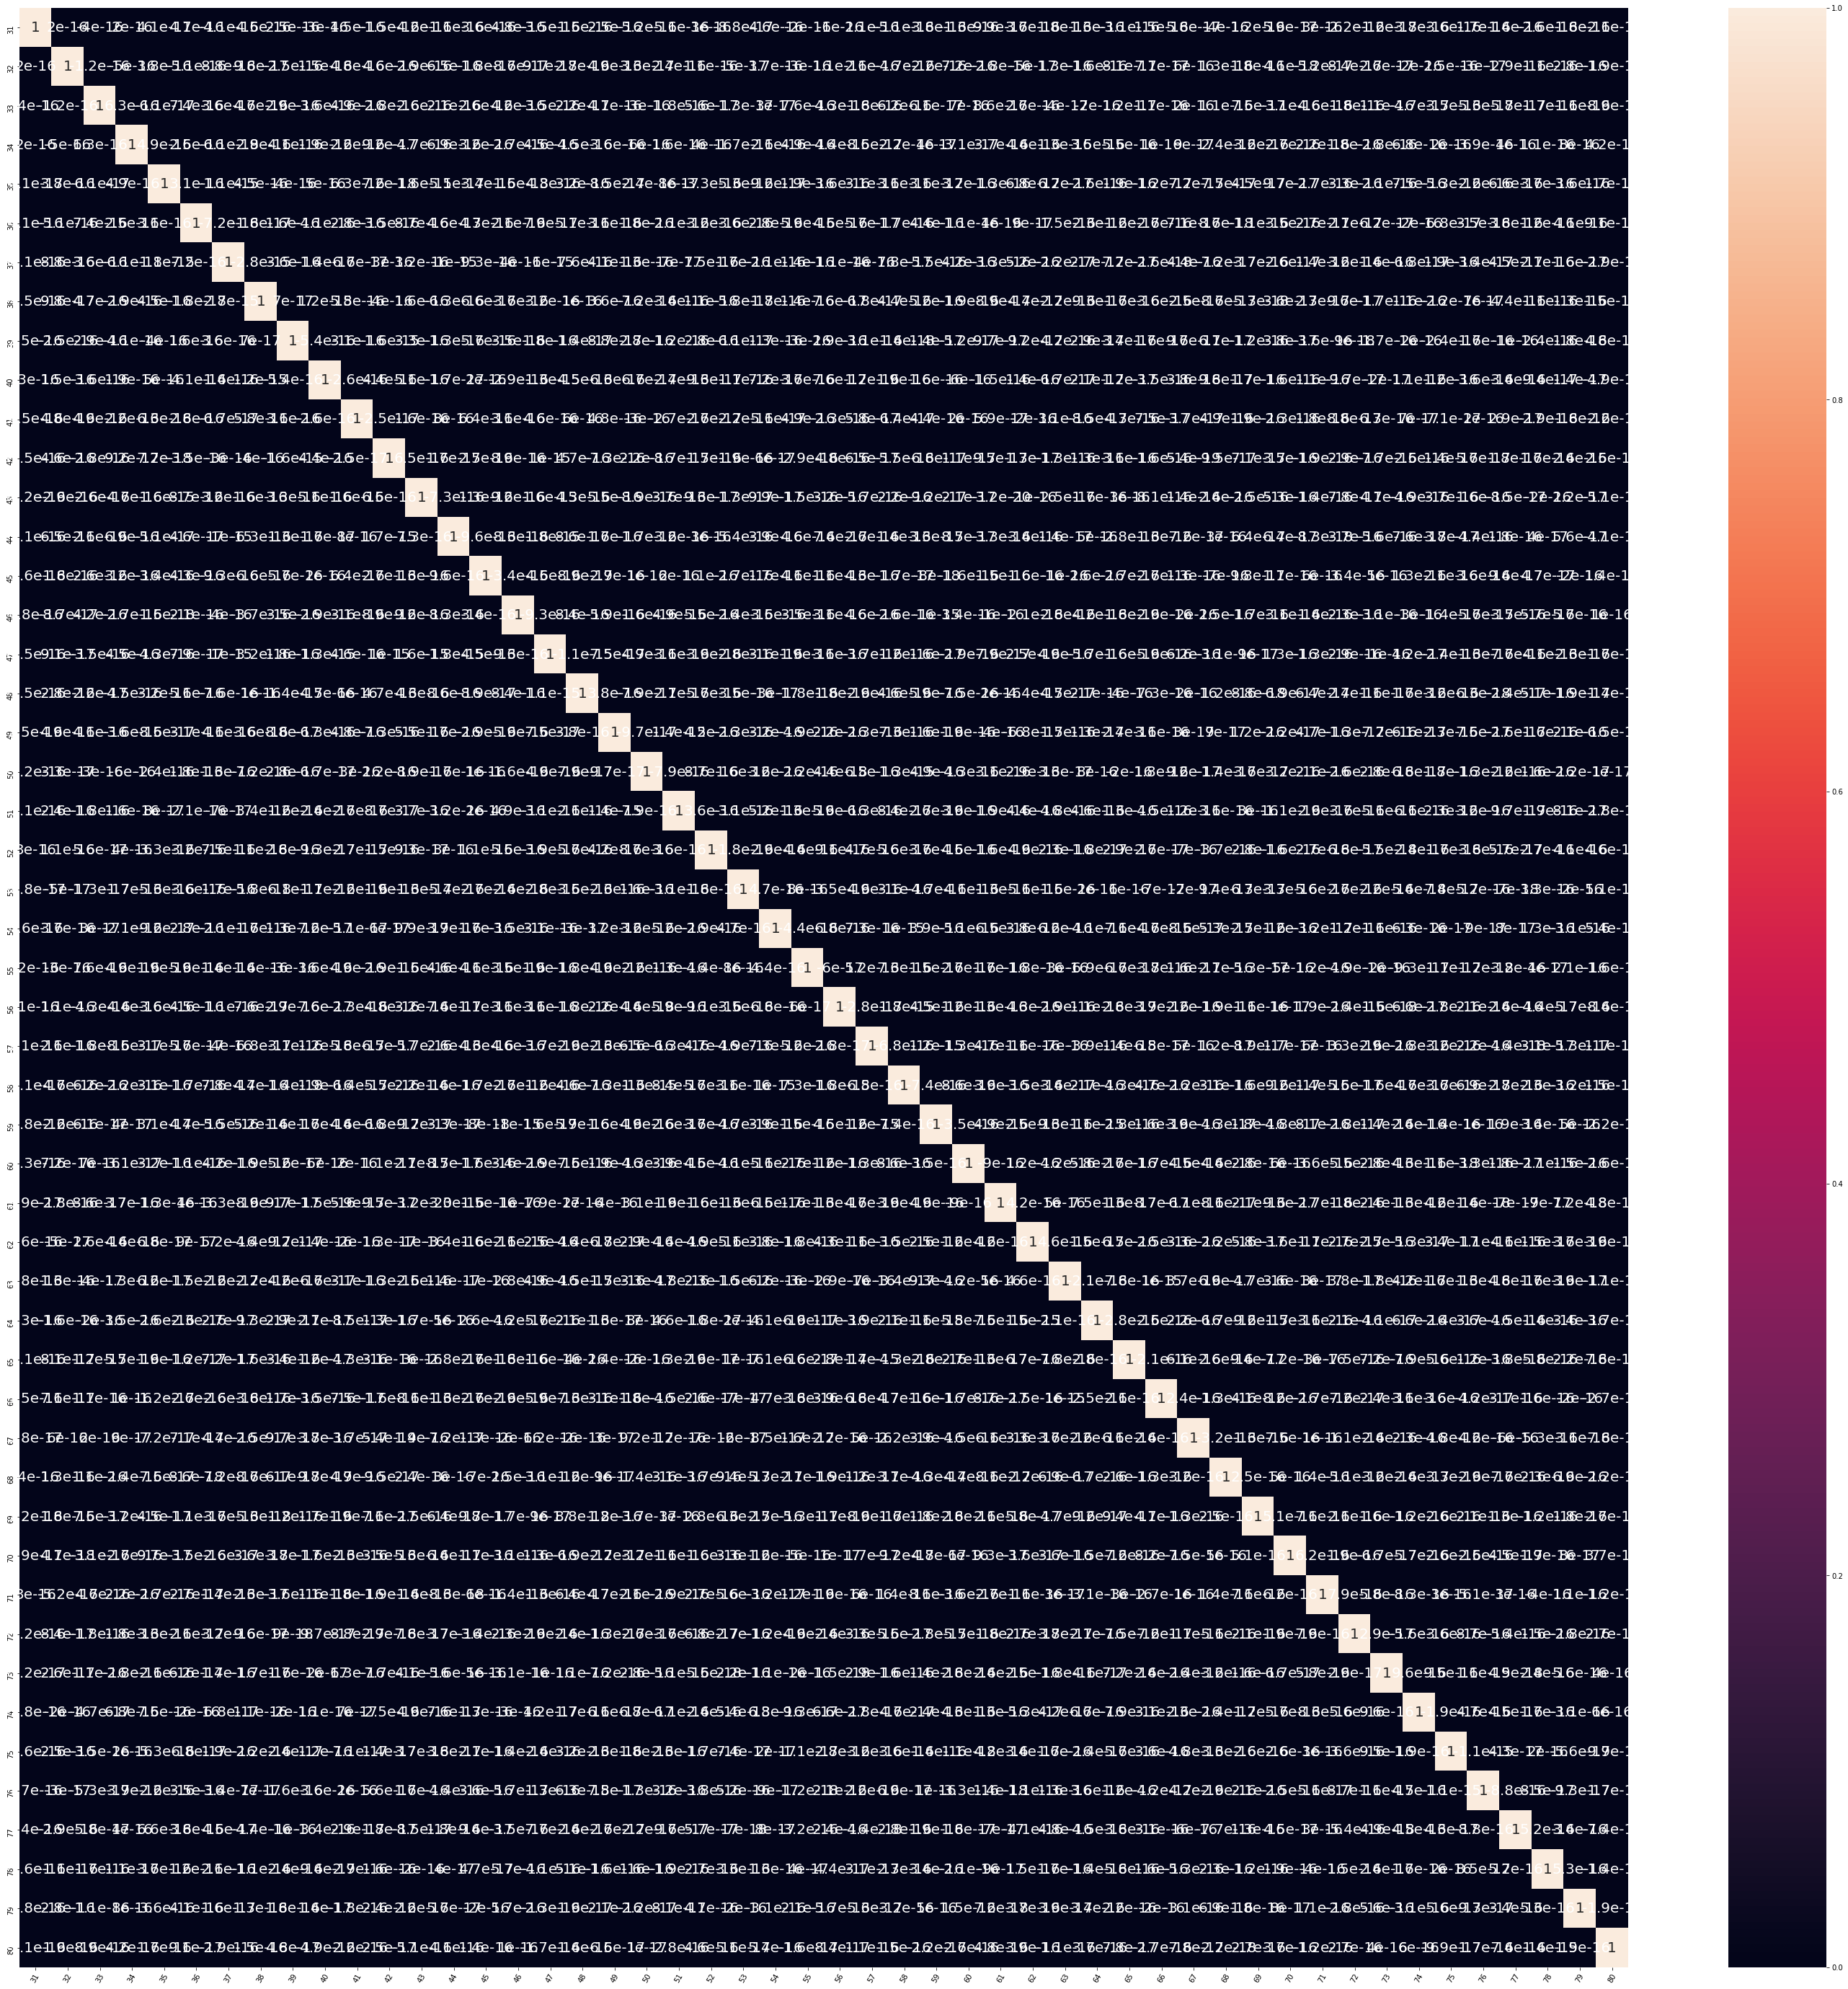

In [12]:
#Correlation Heat Map fo last 51 columns
df_x_51=df_X.iloc[:,31:82]
plt.figure(figsize=(50,50));
a = sns.heatmap(df_x_51.corr(), annot=True, annot_kws={"size": 20});
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=60)
plt.show();

From the above correlation matrix, we can say that there is no co-relation between the columns. That is good for the model. 

### Feature Engineering

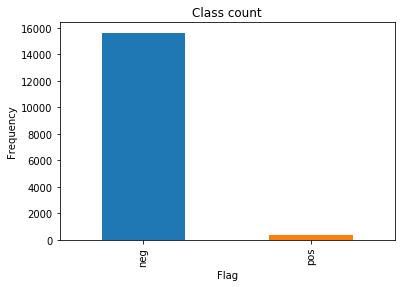

In [13]:
df_test = df_test.rename(columns = {'class' : 'Flag'})
df_test = df_test.replace(['na'],[np.NaN])

Count = pd.value_counts(df_test['Flag'], sort = True).sort_index()
Count.plot(kind = 'bar')
plt.title("Class count")
plt.xlabel("Flag")
plt.ylabel("Frequency")

df_test['Flag'] = df_test.Flag.map({'neg':0, 'pos':1})

df_test_X = df_test.loc[:,df_test.columns != 'Flag']
df_test_Y = df_test.loc[:,df_test.columns == 'Flag']

df_test_X = df_test_X.apply(pd.to_numeric)

df_test_X= df_test_X.fillna(df_test_X.median()).dropna(axis =1 , how ='all')

scaler = StandardScaler()

scaler.fit(df_test_X)

df_test_X = scaler.transform(df_test_X)

pca = PCA(pca_n)
pca.fit(df_test_X)
pca.n_components_
df_test_X = pca.transform(df_test_X)

df_test_X= pd.DataFrame(df_test_X)

Now we have test and training set. Lets create a validation set to tune our parameters for the model. I am splitting our training set here to 80% for training and 20% for validation since we have a separate test data.

In [14]:
X_train,X_validation,Y_train,Y_validation = train_test_split(df_X,df_Y,test_size = 0.2,random_state = 0)
DF = pd.concat([X_train,Y_train],axis = 1)

print("Percentage Neg in training: " , len(Y_train[Y_train.Flag == 0])/len(Y_train))
print("Percentage Pos in training: ", len(Y_train[Y_train.Flag == 1])/len(Y_train))
print("Total number of datapoints in training: ", len(Y_train))


print("Percentage Neg in Validation: " , len(Y_validation[Y_validation.Flag == 0])/len(Y_validation))
print("Percentage Pos in Validation: ", len(Y_validation[Y_validation.Flag == 1])/len(Y_validation))
print("Total number of datapoints in Validation: ", len(Y_validation))

Percentage Neg in training:  0.983
Percentage Pos in training:  0.017
Total number of datapoints in training:  48000
Percentage Neg in Validation:  0.9846666666666667
Percentage Pos in Validation:  0.015333333333333332
Total number of datapoints in Validation:  12000


We have training,validation and test data sets. Since our dataset is highly imbalanced. Lets do some sampling. I am going with undersampling here.

### Undersampling

In [15]:
numberofrecords_pos = len(DF[DF.Flag == 1])
pos_indices = np.array(DF[DF.Flag == 1].index)

#Picking the indices of the normal class
neg_indices = DF[DF.Flag == 0].index

#out of indices selected, randomly select "x" number of records
random_neg_indices = np.random.choice(neg_indices, numberofrecords_pos, replace = False)
random_neg_indices =np.array(random_neg_indices)

#Appending the two indices
under_sample_indices = np.concatenate([pos_indices,random_neg_indices])

#Undersample dataset
under_sample_data = DF.loc[under_sample_indices,:]

X_undersample = under_sample_data.loc[:,under_sample_data.columns != 'Flag']
Y_undersample = under_sample_data.loc[:,under_sample_data.columns == 'Flag']

In [16]:
# Creating Metrics Dataframe
metrics_df = pd.DataFrame(index = ['Metrics_Train','Metrics_Test','Cost'])
metrics_df_copy = pd.DataFrame(index = ['Metrics_Train','Metrics_Test','Cost','Model_Var'])

# Function to print and add metrics to dataframe
def print_metrics(df, model, recall_train,recall_test,cost):
    df[model] = [float("{0:.5f}".format(recall_train)), float("{0:.5f}".format(recall_test)),cost]
    return df

# Function to print and add metrics to dataframe
def print_metrics_copy(df1, model, recall_train,recall_test,cost,model_var):
    df1[model] = [float("{0:.5f}".format(recall_train)), float("{0:.5f}".format(recall_test)),cost,model_var]
    return df1

### Logistic Regression

In [17]:
c_parameter_range = [0.0001,0.001,0.01,0.1,1,10,100]
penalty = ['l1','l2']
for penal in penalty:
    for c_param in c_parameter_range:
        
        print('------------------------')
        print("C Parameter :", c_param)
        print("Penalty: ", penal)
        print('------------------------')
        print('')
        lr = LogisticRegression(C = c_param, penalty = penal)
        lr.fit(X_undersample,Y_undersample.values.ravel())
        y_pred = lr.predict(X_validation)
        Recall = roc_auc_score(Y_validation,y_pred)
        print ('Recall score for c param', c_param,'and penalty',penal,'=',Recall)
        print('-------------------------')
        print('')

------------------------
C Parameter : 0.0001
Penalty:  l1
------------------------

Recall score for c param 0.0001 and penalty l1 = 0.8832993582761767
-------------------------

------------------------
C Parameter : 0.001
Penalty:  l1
------------------------

Recall score for c param 0.001 and penalty l1 = 0.8832993582761767
-------------------------

------------------------
C Parameter : 0.01
Penalty:  l1
------------------------

Recall score for c param 0.01 and penalty l1 = 0.9364402725854405
-------------------------

------------------------
C Parameter : 0.1
Penalty:  l1
------------------------

Recall score for c param 0.1 and penalty l1 = 0.9288529186659209
-------------------------

------------------------
C Parameter : 1
Penalty:  l1
------------------------

Recall score for c param 1 and penalty l1 = 0.951997659768626
-------------------------

------------------------
C Parameter : 10
Penalty:  l1
------------------------

Recall score for c param 10 and penalty l1

In [18]:
lr_train = LogisticRegression(C =0.1,penalty = 'l2')
lr_train.fit(X_undersample,Y_undersample.values.ravel())
y_pred_train = lr_train.predict(X_validation)
recall_train_lr = roc_auc_score(Y_validation,y_pred_train)

In [19]:
lr_test = LogisticRegression(C =0.001,penalty = 'l2')

lr_fit=lr_test.fit(X_undersample,Y_undersample.values.ravel())

y_pred_test = lr_test.predict(df_test_X)

recall_test_lr=roc_auc_score(df_test_Y,y_pred_test)

In [20]:
cm = confusion_matrix(df_test_Y,y_pred_test).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['TN', 'FP', 'FN', 'TP'])
display(cm)

,TN,FP,FN,TP
0,14224,1401,9,366


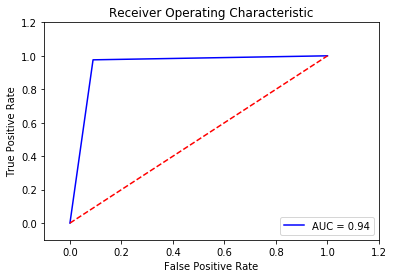

In [21]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_Y,y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [22]:
total_cost = 10*cm.FP + 500*cm.FN
def printmd(string):
    display(Markdown(string))
printmd(f'Total cost is: \n# <p><span style="color:purple">${float(total_cost.values[0])}</span></p>')

Total cost is: 
# <p><span style="color:purple">$18510.0</span></p>

In [23]:
# Printing the training and testing metrices

metrics_df = print_metrics(metrics_df, 'LR_Model', recall_train_lr, recall_test_lr,total_cost[0])
metrics_df_copy = print_metrics_copy(metrics_df_copy, 'LR_Model', recall_train_lr, recall_test_lr,total_cost[0],lr_test)
metrics_df

,LR_Model
Metrics_Train,0.94915
Metrics_Test,0.94317
Cost,18510.00000


### Random Forest

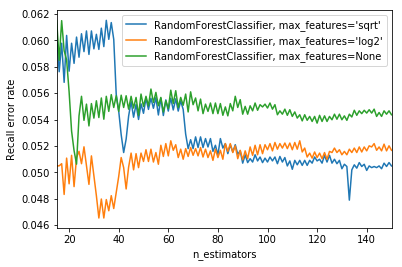

In [24]:
RANDOM_STATE = 123

import warnings
warnings.filterwarnings("ignore")
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 150

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_undersample, Y_undersample)

        # Record the OOB error for each `n_estimators=i` setting.
        y_pred = clf.predict(X_validation)
        recall = roc_auc_score(Y_validation,y_pred)
        error = 1 - recall
        error_rate[label].append((i, error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Recall error rate")
plt.legend(loc="upper right")
plt.show()

In [25]:
clf_train = RandomForestClassifier(n_estimators=80,max_features= 'log2',oob_score =True)

rf_fit=clf_train.fit(X_undersample,Y_undersample.values.ravel())

#clf.oob_score_

y_pred_train_rf = clf_train.predict(X_validation)
recall_train_rf=roc_auc_score(Y_validation,y_pred_train_rf)

In [26]:
clf_test = RandomForestClassifier(n_estimators=30,max_features= 'log2',oob_score =True)

rf_fit=clf_test.fit(X_undersample,Y_undersample.values.ravel())

clf.oob_score_

y_pred_test_rf = clf_test.predict(df_test_X)
recall_test_rf=roc_auc_score(df_test_Y,y_pred_test_rf)

In [27]:
cm = confusion_matrix(df_test_Y,y_pred_test_rf).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['TN', 'FP', 'FN', 'TP'])
display(cm)

,TN,FP,FN,TP
0,13579,2046,9,366


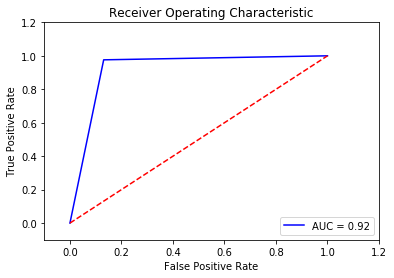

In [28]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_Y,y_pred_test_rf)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
total_cost = 10*cm.FP + 500*cm.FN
def printmd(string):
    display(Markdown(string))
printmd(f'Total cost is: \n# <p><span style="color:purple">${float(total_cost.values[0])}</span></p>')

Total cost is: 
# <p><span style="color:purple">$24960.0</span></p>

In [30]:
# Printing the training and testing metrices
metrics_df = print_metrics(metrics_df, 'RF_Model', recall_train_rf, recall_test_rf,total_cost[0])
metrics_df_copy = print_metrics_copy(metrics_df_copy, 'RF_Model', recall_train_rf, recall_test_rf,total_cost[0],clf_test)
metrics_df

,LR_Model,RF_Model
Metrics_Train,0.94915,0.94523
Metrics_Test,0.94317,0.92253
Cost,18510.00000,24960.00000


### Support Vector Machine

In [31]:
c_parameter_range = [0.001,0.01,0.1,10,100]
kernel = ['linear','poly','rbf','sigmoid']
for kern in kernel:
    for c_param in c_parameter_range:
        print('------------------------')
        print("C Parameter :", c_param)
        print("Kernel: ", kern)
        print('------------------------')
        print('')
        clf = svm.SVC(C = c_param,kernel = kern,gamma = 0.01)
        clf.fit(X_undersample,Y_undersample)
        y_pred = clf.predict(X_validation)
        Recall = roc_auc_score(Y_validation,y_pred)
        print ('Recall Score for c parameter', c_param, 'and kernel',kern,'=',Recall)
        print('-------------------------')
        print('')

------------------------
C Parameter : 0.001
Kernel:  linear
------------------------

Recall Score for c parameter 0.001 and kernel linear = 0.9382414412292838
-------------------------

------------------------
C Parameter : 0.01
Kernel:  linear
------------------------

Recall Score for c parameter 0.01 and kernel linear = 0.9438031703511819
-------------------------

------------------------
C Parameter : 0.1
Kernel:  linear
------------------------

Recall Score for c parameter 0.1 and kernel linear = 0.9518283977510229
-------------------------

------------------------
C Parameter : 10
Kernel:  linear
------------------------

Recall Score for c parameter 10 and kernel linear = 0.9310386064584499
-------------------------

------------------------
C Parameter : 100
Kernel:  linear
------------------------

Recall Score for c parameter 100 and kernel linear = 0.9275172205704866
-------------------------

------------------------
C Parameter : 0.001
Kernel:  poly
-----------------

In [32]:
svm_train = svm.SVC(C =0.1,gamma = 0.01, kernel = 'sigmoid')

svm_fit=svm_train.fit(X_undersample,Y_undersample)
y_pred_train_svm = svm_train.predict(X_validation)
recall_train_svm=roc_auc_score(Y_validation,y_pred_train_svm)

In [33]:
svm_test = svm.SVC(C =0.01,gamma = 0.01, kernel = 'sigmoid')

svm_fit=svm_test.fit(X_undersample,Y_undersample)
y_pred_test_svm = svm_test.predict(df_test_X)
recall_test_svm=roc_auc_score(df_test_Y,y_pred_test_svm)

In [34]:
cm = confusion_matrix(df_test_Y,y_pred_test_svm).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['TN', 'FP', 'FN', 'TP'])
display(cm)

,TN,FP,FN,TP
0,13347,2278,8,367


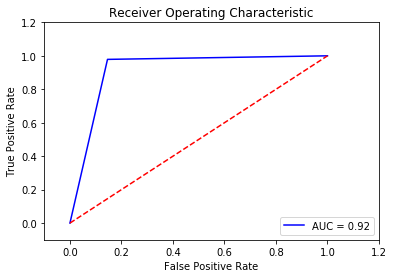

In [35]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_Y,y_pred_test_svm)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [36]:
total_cost = 10*cm.FP + 500*cm.FN
def printmd(string):
    display(Markdown(string))
printmd(f'Total cost is: \n# <p><span style="color:purple">${float(total_cost.values[0])}</span></p>')

Total cost is: 
# <p><span style="color:purple">$26780.0</span></p>

In [37]:
# Printing the training and testing metrices
metrics_df = print_metrics(metrics_df, 'SVM_Model', recall_train_svm, recall_test_svm,total_cost[0])
metrics_df_copy = print_metrics_copy(metrics_df_copy, 'SVM_Model', recall_train_svm, recall_test_svm,total_cost[0],svm_test)
metrics_df

,LR_Model,RF_Model,SVM_Model
Metrics_Train,0.94915,0.94523,0.83320
Metrics_Test,0.94317,0.92253,0.91644
Cost,18510.00000,24960.00000,26780.00000


### XGBoost 

In [38]:
from xgboost import XGBClassifier
xgb=XGBClassifier()

xgb_fit=xgb.fit(X_undersample,Y_undersample.values.ravel())

y_pred_train_xgb = xgb.predict(X_validation)
recall_train_xgb=roc_auc_score(Y_validation,y_pred_train_xgb)

In [39]:
y_pred_test_xgb = xgb.predict(df_test_X)
recall_test_xgb=roc_auc_score(df_test_Y,y_pred_test_xgb)

In [40]:
cm = confusion_matrix(df_test_Y,y_pred_test_xgb).ravel()
cm = pd.DataFrame(cm.reshape((1,4)), columns=['TN', 'FP', 'FN', 'TP'])
display(cm)

,TN,FP,FN,TP
0,14449,1176,16,359


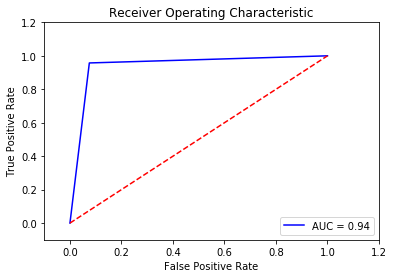

In [41]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_Y,y_pred_test_xgb)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [42]:
total_cost = 10*cm.FP + 500*cm.FN
def printmd(string):
    display(Markdown(string))
printmd(f'Total cost is: \n# <p><span style="color:purple">${float(total_cost.values[0])}</span></p>')

Total cost is: 
# <p><span style="color:purple">$19760.0</span></p>

In [43]:
# Printing the training and testing metrices
metrics_df = print_metrics(metrics_df, 'XGB_Model', recall_train_xgb, recall_test_xgb,total_cost[0])
metrics_df_copy = print_metrics_copy(metrics_df_copy, 'XGB_Model', recall_train_svm, recall_test_svm,total_cost[0],xgb)
metrics_df

,LR_Model,RF_Model,SVM_Model,XGB_Model
Metrics_Train,0.94915,0.94523,0.83320,0.94515
Metrics_Test,0.94317,0.92253,0.91644,0.94103
Cost,18510.00000,24960.00000,26780.00000,19760.00000


In [44]:
metrics_df=metrics_df.T
metrics_df_copy=metrics_df_copy.T
metrics_df

,Metrics_Train,Metrics_Test,Cost
LR_Model,0.94915,0.94317,18510.0
RF_Model,0.94523,0.92253,24960.0
SVM_Model,0.83320,0.91644,26780.0
XGB_Model,0.94515,0.94103,19760.0


In [45]:
#Ranking of the model
metrics_df['Model_Rank'] = metrics_df['Cost'].rank(ascending=True,method='max')
metrics_df['Model_Rank']=metrics_df['Model_Rank'].astype(int)
metrics_df['Model_Name']=['Logistic Regression','Random Forest','Support Vector Machine','XG Boost']
metrics_df_copy['Model_Rank'] = metrics_df_copy['Cost'].rank(ascending=True,method='max')
metrics_df_copy['Model_Rank']=metrics_df_copy['Model_Rank'].astype(int)
metrics_df

,Metrics_Train,Metrics_Test,Cost,Model_Rank,Model_Name
LR_Model,0.94915,0.94317,18510.0,1,Logistic Regression
RF_Model,0.94523,0.92253,24960.0,3,Random Forest
SVM_Model,0.83320,0.91644,26780.0,4,Support Vector Machine
XGB_Model,0.94515,0.94103,19760.0,2,XG Boost


The above metrics shows the Machine Learning models with the accuracy and the rank based on the cost.

In [46]:
# Store the result into csv
metrics_df.to_csv('Metrics_Score.csv', index=False)

### Pickle

Pickle is the standard way of serializing objects in Python. We can use the pickle operation to serialize our machine learning algorithms and save the serialized format to a file.
Later we can load this file to deserialize your model and use it to make new predictions.

In [47]:
dictionary1=pd.Series(metrics_df.Model_Name.values,index=metrics_df.Model_Rank).to_dict()
print('Dictionary with Model Rank as Key and Model Name as values ',dictionary1)
dictionary2=pd.Series(metrics_df_copy.Model_Var.values,index=metrics_df_copy.Model_Rank).to_dict()
print('Dictionary with Model Rank as Key and Model_Var as values ',dictionary2)

Dictionary with Model Rank as Key and Model Name as values  {1: 'Logistic Regression', 3: 'Random Forest', 4: 'Support Vector Machine', 2: 'XG Boost'}
Dictionary with Model Rank as Key and Model_Var as values  {1: LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 3: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False), 4: SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, ga

In [48]:
from collections import defaultdict
ds = [dictionary1, dictionary2]

dictionary = {}
for k in dictionary1.keys():
    dictionary[k] = tuple(dictionary[k] for dictionary in ds)

In [49]:
# save the model to disk
filename = 'finalized_model.pkl'
pickle.dump(dictionary, open(filename, 'wb'),protocol=2)